# AG2 - Actividad Guiada 2

Nombre: Carlos Javier Bravo Intriago

https://colab.research.google.com/drive/1Nuj5Gf1vmRnA6Lg4XHXRs-Fx62q9rHlq?usp=sharing

https://github.com/carlosbravo1408/03MIAR-Algoritmos-de-Optimizacion-2025/tree/main/AG2




In [60]:
# paquete personalizado, creado exclusivamente para una mejor representación visual a los resultados de este Notebook
!pip install git+https://github.com/carlosbravo1408/03MIAR-Algoritmos-de-Optimizacion-2025.git@AG2


[notice] A new release of pip is available: 24.3.1 -> 26.0
[notice] To update, run: pip install --upgrade pip
ERROR: git+https://github.com/carlosbravo1408/03MIAR-Algoritmos-de-Optimizacion-2025.git@AG2 does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [ ]:
import math
import time
import random
import decimal
import tracemalloc
from functools import wraps
from collections import defaultdict
from typing import List, Union, Tuple, Dict, Optional, Set, Callable

from MIAR03.beauty_printer import print_matrix, ConsoleColors

inf = float('inf')
NumericType = Union[float, int, decimal.Decimal]
FaresType = List[List[NumericType]]
PricesType = List[List[NumericType]]
PathsType = List[List[NumericType]]


# Decorador medidor de tiempo
def measure_time(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.monotonic()
        result = func(*args, **kwargs)
        end_time = time.monotonic()
        elapsed_time = end_time - start_time
        if isinstance(result, tuple) and len(result) >= 2 and isinstance(result[-1], dict) and ("time" in result[-1] or "memory" in result[-1]):
            result[-1]["time"] = elapsed_time
            return result
        else:
            return result, {"time": elapsed_time}
    return wrapper


# Decorador medidor de Memoria
def measure_memory(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        tracemalloc.start()
        result = func(*args, **kwargs)
        _, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        # 1 << 10 = 1024, 1 << (10*2) = 1024**2  Conversion a MB
        peak = peak / (1 << (10 * 2))
        if isinstance(result, tuple) and len(result) >= 2 and isinstance(result[-1], dict)  and ("time" in result[-1] or "memory" in result[-1]):
            result[-1]["memory"] = peak
            return result
        else:
            return result, {"memory": peak}

    return wrapper

# método para generar las matrices de tarea/agente aleatorias
def generate_random_task_list(n: int, start: int = 1, stop: int = 100, seed: Optional[int] = None) -> List[List[int]]:
    if seed is not None:
        random.seed(seed)
    return [[random.randrange(start, stop) for _ in range(n)] for _ in range(n)]


## 1. Programación Dinámica. Viaje por el río
* **Definición**: Es posible dividir el problema en subproblemas más pequeños, guardando las soluciones para ser utilizadas más adelante.
* **Características** que permiten identificar problemas aplicables:<br>
  -Es posible almacenar soluciones de los subproblemas para ser utilizados más adelante<br>
  -Debe verificar el principio de optimalidad de Bellman: “en una secuencia óptima de decisiones, toda sub-secuencia también es óptima” (*)<br>
  -La necesidad de guardar la información acerca de las soluciones parciales unido a la recursividad provoca la necesidad de preocuparnos por la complejidad espacial (cuantos recursos de espacio usaremos)<br>

### A. Problema<br>
En un río hay `n` embarcaderos y debemos desplazarnos río abajo desde un embarcadero a otro. Cada embarcadero tiene precios diferentes para ir de un embarcadero a otro situado más abajo. Para ir del embarcadero i al j, puede ocurrir que sea más barato hacer un trasbordo por un embarcadero intermedio k. El problema consiste en determinar la combinación más barata.

<div style="flex: 0 0 100px; text-align: center;">
        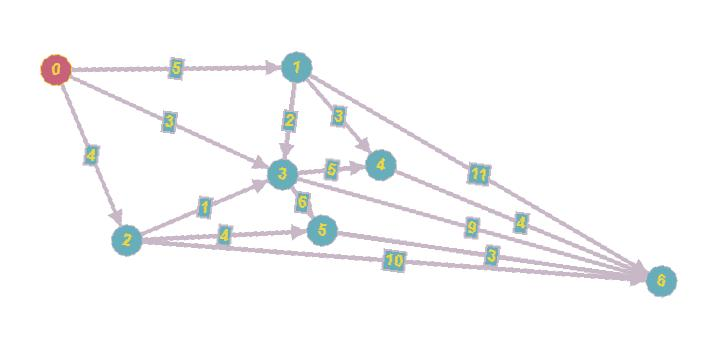
        <p style="text-align: center; font-size: 0.85em; margin-top: 5px; line-height: 1.2;">Fig 1. Problema del viaje por el río.</p>
    </div>
</div>



* Consideramos una tabla TARIFAS(i,j) para almacenar todos los precios que nos ofrecen los embarcaderos.
* Si no es posible ir desde i a j daremos un valor alto para garantizar que ese trayecto no se va a elegir en la ruta óptima(modelado habitual para restricciones)

In [3]:
#Viaje por el río - Programación dinámica

TARIFAS = [
    #   0    1    2    3    4    5    6
    [   0,   5,   4,   3, inf, inf, inf],  # 0
    [ inf,   0, inf,   2,   3, inf,  11],  # 1
    [ inf, inf,   0,   1, inf,   4,  10],  # 2
    [ inf, inf, inf,   0,   5,   6,   9],  # 3
    [ inf, inf, inf, inf,   0, inf,   4],  # 4
    [ inf, inf, inf, inf, inf,   0,   3],  # 5
    [ inf, inf, inf, inf, inf, inf,   0]   # 6
]

print_matrix(TARIFAS, title="Tarifas")

                    Tarifas                    
-----------------------------------------------
          0     1     2     3     4     5     6
    -------------------------------------------
  0 |     0     5     4     3     ∞     ∞     ∞
  1 |     ∞     0     ∞     2     3     ∞    11
  2 |     ∞     ∞     0     1     ∞     4    10
  3 |     ∞     ∞     ∞     0     5     6     9
  4 |     ∞     ∞     ∞     ∞     0     ∞     4
  5 |     ∞     ∞     ∞     ∞     ∞     0     3
  6 |     ∞     ∞     ∞     ∞     ∞     ∞     0



In [4]:
@measure_time
@measure_memory
def precios(tarifas: FaresType) -> Tuple[PricesType, PathsType]:
    """
    - Autor: Mónica Sánchez Cuberes (Con ayuda de Claude de Anthropic). Corrección sugerida en el Foro
    - Modificado por: Carlos Javier Bravo Intriago
    - Fecha: Enero 2026
    -----------------------

    Cálculo de la matriz de PRECIOS y RUTAS\n
    Precios - contiene la matriz del mejor precio para ir de un nodo a otro\n
    Rutas - contiene los nodos intermedios para ir de un nodo a otro

    Este código se basa en el algoritmo de Floyd-Warshall, el cual fue
    sugerencia propuesta por Mónica Sánchez Cuberes como parte de una
    corrección sugerida en el Foro. Las salidas de las tuplas obedecen a la
    forma canónica de D (Matriz Distancias o pesos), y Π (Matriz de
    predecesores)

    Complejidad temporal O(N³)

    Cambios:
    -----------------------
    * [1] Se agregaron validaciones para evitar recorrer el bucle si no existe
      conexión
    * [2] Se omite que se rellene con valores de `i` por debajo de la diagonal
      principal si no existe conexión alguna con otro nodo


    ----------------
    :param tarifas: Matriz de tarifas (costos) entre nodos
    :return: Tupla con los arreglos de Precios y Rutas de forma canónica
    """
    n = len(tarifas)

    _precios = [tarifa[:] for tarifa in tarifas]
    rutas = [[i if i != j and tarifas[i][j] != inf else -1 for j in range(n)]
             for i in range(n)]  # [2]
    for k in range(n):
        for i in range(n):
            if _precios[i][k] == inf:  # [1]
                continue
            for j in range(n):
                if _precios[k][j] == inf:  # [1]
                    continue
                if _precios[i][k] + _precios[k][j] < _precios[i][j]:
                    _precios[i][j] = _precios[i][k] + _precios[k][j]
                    rutas[i][j] = rutas[k][j]  # Resultado en forma Canónica
    return _precios, rutas

In [5]:
(PRECIOS, RUTA), estadisticas = precios(TARIFAS)
print(estadisticas)

{'memory': 0.00140380859375, 'time': 9.009900168166496e-05}


In [6]:
print_matrix(PRECIOS, title="Precios")

                    Precios                    
-----------------------------------------------
          0     1     2     3     4     5     6
    -------------------------------------------
  0 |     0     5     4     3     8     8    11
  1 |     ∞     0     ∞     2     3     8     7
  2 |     ∞     ∞     0     1     6     4     7
  3 |     ∞     ∞     ∞     0     5     6     9
  4 |     ∞     ∞     ∞     ∞     0     ∞     4
  5 |     ∞     ∞     ∞     ∞     ∞     0     3
  6 |     ∞     ∞     ∞     ∞     ∞     ∞     0



In [7]:
print_matrix(RUTA, title="Ruta")

                     Ruta                      
-----------------------------------------------
          0     1     2     3     4     5     6
    -------------------------------------------
  0 |    -1     0     0     0     1     2     5
  1 |    -1    -1    -1     1     1     3     4
  2 |    -1    -1    -1     2     3     2     5
  3 |    -1    -1    -1    -1     3     3     3
  4 |    -1    -1    -1    -1    -1    -1     4
  5 |    -1    -1    -1    -1    -1    -1     5
  6 |    -1    -1    -1    -1    -1    -1    -1



In [8]:
def calcular_ruta(ruta: PathsType, desde: int, hasta: int) -> List[int]:
    """
    Algoritmo recursivo que retorna la ruta de menor coste a partir del resultado de rutas bajo la forma canónica de Π (Matriz de predecesores)

    :param ruta: Matriz con las rutas de la forma canónica de Π (Matriz de predecesores)
    :param desde: Nodo origen
    :param hasta: Nodo destino
    :return: Ruta más corta desde el origen hasta el destino.
    """
    if desde == hasta:
        return [desde]
    predecesor = ruta[desde][hasta]
    if predecesor == -1:
        return []
    camino_previo = calcular_ruta(ruta, desde, predecesor)
    if not camino_previo:
        return []
    return camino_previo + [hasta]

In [9]:
print("La ruta es:")
print(calcular_ruta(RUTA, 0, 6))

La ruta es:
[0, 2, 5, 6]


In [10]:
TARIFAS_MONICA = [
    #   0    1    2    3    4
    [   0, inf,   2, inf, inf],  # 0
    [   1,   0, inf, inf, inf],  # 1
    [ inf, inf,   0, inf,  10],  # 2
    [ inf,   1, inf,   0, inf],  # 3
    [ inf, inf, inf,   5,   0]   # 4
]
print_matrix(TARIFAS_MONICA, title="Tarifas, Ejemplo de Monica Sánchez")

(PRECIOS_MONICA, RUTA_MONICA), statics = precios(TARIFAS_MONICA)
print(statics)
print_matrix(PRECIOS_MONICA, title="Precios, Ejemplo de Monica Sánchez")
print_matrix(RUTA_MONICA, title="Ruta, Ejemplo de Monica Sánchez")

print(f"La ruta es:{calcular_ruta(RUTA_MONICA, 1, 4)}")

Tarifas, Ejemplo de Monica Sánchez 
-----------------------------------
          0     1     2     3     4
    -------------------------------
  0 |     0     ∞     2     ∞     ∞
  1 |     1     0     ∞     ∞     ∞
  2 |     ∞     ∞     0     ∞    10
  3 |     ∞     1     ∞     0     ∞
  4 |     ∞     ∞     ∞     5     0

{'memory': 0.001068115234375, 'time': 9.773800047696568e-05}
Precios, Ejemplo de Monica Sánchez 
-----------------------------------
          0     1     2     3     4
    -------------------------------
  0 |     0    18     2    17    12
  1 |     1     0     3    18    13
  2 |    17    16     0    15    10
  3 |     2     1     4     0    14
  4 |     7     6     9     5     0

  Ruta, Ejemplo de Monica Sánchez  
-----------------------------------
          0     1     2     3     4
    -------------------------------
  0 |    -1     3     0     4     2
  1 |     1    -1     0     4     2
  2 |     1     3    -1     4     2
  3 |     1     3     0    -1     2
 

### B. Resolviendo el problema del río con el algoritmo de Dijkstra



In [11]:
Node = int
Weight = NumericType
Graph = Dict[Node, List[Tuple[Node, Weight]]]


def create_graph(fares: FaresType) -> Graph:
    """
    Método que convierte una matriz de Adyacencia en una estructura tipo grafo.
    :param fares: Matriz de Adyacencia
    :return: Grafo
    """
    graph = defaultdict(list)
    for i in range(len(fares)):
        for j in range(len(fares[i])):
            if math.isinf(fares[i][j]):
                continue
            graph[i].append((j, fares[i][j]))
    return graph


In [12]:
graph = create_graph(fares=TARIFAS)
graph

defaultdict(list,
            {0: [(0, 0), (1, 5), (2, 4), (3, 3)],
             1: [(1, 0), (3, 2), (4, 3), (6, 11)],
             2: [(2, 0), (3, 1), (5, 4), (6, 10)],
             3: [(3, 0), (4, 5), (5, 6), (6, 9)],
             4: [(4, 0), (6, 4)],
             5: [(5, 0), (6, 3)],
             6: [(6, 0)]})

In [13]:
from heapq import heappush, heappop  # Cola de prioridad

# Observación: Este algoritmo se puede optimizar un poco más evitando crear la lista de rutas, lo ideal sería hacer referencia que nodo es predecesor de otro, y de manera recursiva encontrar la ruta minima.
@measure_time
@measure_memory
def dijkstra(graph: Graph, source: Node) -> Tuple[Dict[Node, List[Node]], Dict[Node, Weight]]:
    """
    Algoritmo de Dijkstra modificado para resolver el problema del río, es una propuesta basada en SSSP (Single-Source Shortest Path) en el supuesto de que siempre se parta del mismo origen (en este caso el nodo 0), este algoritmo retornara todas rutas más cortas desde el origen antes definido.

    Complejidad temporal: O(|E| + |V|log|V|)

    :param graph: Grafo
    :param source: Nodo Origen
    :return: Colección de rutas y de distancias mínimas.
    """
    dist: Dict[Node, Weight] = {v: inf for v in graph}
    dist[source] = 0.0
    paths: Dict[Node, List[Node]] = {source: [source]}
    heap: List[Tuple[Weight, Node]] = [(0.0, source)]
    while heap:
        current_weight, current_node = heappop(heap)
        if current_weight > dist[current_node]:
            continue
        if current_node not in paths:
            paths[current_node] = []
        for node, weight in graph[current_node]:  # Visitando vecinos / hijos
            sum_weights = current_weight + weight
            if sum_weights < dist.get(node, inf):
                paths[node] = paths[current_node] + [node]
                dist[node] = sum_weights
                heappush(heap, (sum_weights, node))

    return paths, dist

In [14]:
(paths, dist), stats = dijkstra(graph, 0)
print(stats)
print("\nRutas mas cortas desde el Nodo 0")
print(paths)
print("\nCostos minimizados desde el Nodo 0")
print(dist)
print("\nLa ruta desde 0 hasta 6 es:")
print(paths[6])

{'memory': 0.000946044921875, 'time': 4.8227000661427155e-05}

Rutas mas cortas desde el Nodo 0
{0: [0], 1: [0, 1], 2: [0, 2], 3: [0, 3], 4: [0, 3, 4], 5: [0, 2, 5], 6: [0, 2, 5, 6]}

Costos minimizados desde el Nodo 0
{0: 0.0, 1: 5.0, 2: 4.0, 3: 3.0, 4: 8.0, 5: 8.0, 6: 11.0}

La ruta desde 0 hasta 6 es:
[0, 2, 5, 6]


In [15]:
graph_monica = create_graph(fares=TARIFAS_MONICA)
(paths_monica, dist_monica), stats = dijkstra(graph_monica, 1)
print(stats)
print("\nRutas mas cortas desde el Nodo 0")
print(paths_monica)
print("\nCostos minimizados desde el Nodo 0")
print(dist_monica)
print("\nLa ruta desde 1 hasta 4 es:")
print(paths_monica[4])

{'memory': 0.00023651123046875, 'time': 5.680599861079827e-05}

Rutas mas cortas desde el Nodo 0
{1: [1], 0: [1, 0], 2: [1, 0, 2], 4: [1, 0, 2, 4], 3: [1, 0, 2, 4, 3]}

Costos minimizados desde el Nodo 0
{0: 1.0, 1: 0.0, 2: 3.0, 3: 18.0, 4: 13.0}

La ruta desde 1 hasta 4 es:
[1, 0, 2, 4]


## 2. Problema de Asignación de tarea - Ramificación y Poda

El objetivo es asignar `n` tareas a `n` agentes de forma que el costo total sea el mínimo posible, bajo la restricción de que cada agente realiza exactamente una tarea y cada tarea es realizada por un solo agente.
```
|     |  T  |  A  |  R  |  E  |  A  |
| --- | --- | --- | --- | --- | --- |
|  A  |     |     |     |     |     |
|  G  |     |     |     |     |     |
|  E  |     |     |     |     |     |
|  N  |     |     |     |     |     |
|  T  |     |     |     |     |     |
|  E  |     |     |     |     |     |

```

In [16]:
COSTES = [
    #T0, T1, T2, T3
    [11, 12, 18, 40],  # A0
    [14, 15, 13, 22],  # A1
    [11, 17, 19, 23],  # A2
    [17, 14, 20, 28]   # A3
]

print_matrix(COSTES, header_col_char="T", header_row_char="A")


In [17]:
def valor(solucion_parcial: Tuple[NumericType, ...], matriz_de_costes: List[List[NumericType]]) -> NumericType:
    """
    Función que calcula el valor de una unica `solucion_parcial`

    :param solucion_parcial:
    :param matriz_de_costes:
    :return: Suma de costes de esa solución parcial.
    """
    acumulador = 0
    for i in range(len(solucion_parcial)):
        acumulador += matriz_de_costes[solucion_parcial[i]][i]
    return acumulador


valor((3, 2,), COSTES)

34

In [18]:
def coste_inferior(solucion_parcial: Tuple[NumericType, ...], matriz_de_costes: List[List[NumericType]]) -> NumericType:
    """
    Coste inferior para soluciones parciales\n
    (1,3,) Se asigna la tarea 1 al agente 0 y la tarea 3 al agente 1
    :param solucion_parcial:
    :param matriz_de_costes:
    :return:
    """
    acumulador = 0
    #Valores establecidos
    for i in range(len(solucion_parcial)):
        acumulador += matriz_de_costes[i][solucion_parcial[i]]

    #Estimacion
    for i in range(len(solucion_parcial), len(matriz_de_costes)):
        acumulador += min([matriz_de_costes[j][i] for j in range(len(solucion_parcial), len(matriz_de_costes))])
    return acumulador


def coste_superior(solucion_parcial: Tuple[NumericType, ...], matriz_de_costes: List[List[NumericType]]) -> NumericType:
    """
    Coste superior para soluciones parciales\n
    (1,3,) Se asigna la tarea 1 al agente 0 y la tarea 3 al agente 1
    :param solucion_parcial:
    :param matriz_de_costes:
    :return:
    """
    acumulador = 0
    #Valores establecidos
    for i in range(len(solucion_parcial)):
        acumulador += matriz_de_costes[i][solucion_parcial[i]]

    #Estimacion
    for i in range(len(solucion_parcial), len(matriz_de_costes)):
        acumulador += max([matriz_de_costes[j][i] for j in range(len(solucion_parcial), len(matriz_de_costes))])
    return acumulador


print(coste_inferior((0, 1), COSTES))
print(coste_superior((0, 1), COSTES))

68
74


In [19]:
def crear_hijos(nodo: Tuple[NumericType, ...], dimension: int) -> List[Dict[str, Tuple[NumericType, ...]]]:
    """
    Método que genera nuevas ramificaciones, nuevos nodos hijos que sean posibles como siguiente elemento de la tupla de solución parcial\n
    >>> crear_hijos(nodo=(0,), dimension=4)
    [{'s': (0, 1)}, {'s': (0, 2)}, {'s': (0, 3)}]
    :param nodo:
    :param dimension:
    :return: Lista de nodos hijos posibles.
    """
    hijos = []
    for i in range(dimension):
        if i not in nodo:
            hijos.append({'s': nodo + (i,)})
    return hijos

crear_hijos((0,), 4)

[{'s': (0, 1)}, {'s': (0, 2)}, {'s': (0, 3)}]

In [20]:
@measure_time
@measure_memory
def ramificacion_y_poda(matriz_de_costes):
    """
    - Autor: Raúl Reyero
    -----------------------

    Algoritmo que busca asignar tareas a los respectivos agentes de tal forma que el costo entre estas sea el minimo.\n
    Construcción iterativa de soluciones(arbol). En cada etapa asignamos un agente(ramas).\n
    Nodos del grafo { s: (1, 2), CI: 3, CS: 5 }

    :param matriz_de_costes:
    :return: La lista de Tareas por agente.
    """

    dimension = len(matriz_de_costes)
    mejor_solucion = tuple(i for i in range(len(matriz_de_costes)))
    cota_sup = valor(mejor_solucion, matriz_de_costes)

    nodos = [{'s': (), 'ci': coste_inferior((), matriz_de_costes)}]

    iteracion = 0

    while len(nodos) > 0:
        iteracion += 1

        nodo_prometedor = [min(nodos, key=lambda x: x['ci'])][0]['s']

        # Ramificación: Se generan los hijos
        hijos = [
            {'s': x['s'], 'ci': coste_inferior(x['s'], matriz_de_costes)}
            for x in crear_hijos(nodo_prometedor, dimension)
        ]

        # Revisamos la cota superior y nos quedamos con la mejor solucion si llegamos a una solucion final
        nodo_final = [x for x in hijos if len(x['s']) == dimension]
        if len(nodo_final) > 0:
            if nodo_final[0]['ci'] < cota_sup:
                cota_sup = nodo_final[0]['ci']
                mejor_solucion = nodo_final

        # Poda
        hijos = [x for x in hijos if x['ci'] < cota_sup]

        # Añadimos los hijos
        nodos.extend(hijos)

        # Eliminamos el nodo ramificado
        nodos = [x for x in nodos if x['s'] != nodo_prometedor]

    return (mejor_solucion[0]['s'], mejor_solucion[0]['ci']), iteracion


In [21]:
(solution, iterations), estadisticas = ramificacion_y_poda(COSTES)
print_matrix(COSTES, solution[0], title="Matriz de Costes",header_col_char="T", header_row_char="A")

print(f"Tiempo de ejecucion: {estadisticas['time']}, Memoria usada: {estadisticas['memory']}")
print(f"Solucion: {solution[0]}, con un coste de {solution[1]} en {iterations} iteraciones")

      Matriz de Costes       
Leyenda:  Sol 1 
-----------------------------
         T0    T1    T2    T3
    -------------------------
 A0 |    11    12    18    40
 A1 |    14    15    13    22
 A2 |    11    17    19    23
 A3 |    17    14    20    28

Tiempo de ejecucion: 0.00037830100336577743, Memoria usada: 0.0022430419921875
Solucion: (1, 2, 0, 3), con un coste de 64 en 10 iteraciones


### A. Implementación de estrategia de ramificación y poda más cola de prioridad:

En esta version, se ha decidido experimentar un híbrido entre una estrategia
de Búsqueda Uniforme de costes, implementando una cola de prioridad (similar
a Dijkstra Modificado). El objetivo es seleccionar en cada iteración el nodo
 prometedor con la menor Cota Inferior (`lower_bound`) estimada, guiando la
 exploración hacia la solución óptima de manera más eficiente.

Para facilitar la ramificación, se ha creado una estructura llamada `Node`,
la cual tiene por atributos:
* `agent`: Agente al que pertenece
* `task`: Tarea asignada
* `cost`: costo de esa tarea para el agente asignado
* `parent`: nodo predecesor
* `lower_cost`: cota inferior asociada a esa tarea y agente
* `satisfied_task`: tareas satisfechas hasta el agente perteneciente a ese Nodo

En las pruebas realizadas (no tan profunda ni rigurosamente) en el notebook
[AsignacionDeTareas](./AG2/AsignacionDeTareas.ipynb) se explora este
algoritmo tanto si se obtiene el primer resultado que satisface al problema
(como una parada temprana), o si se explora las soluciones posibles antes de
retornar la solución con menor coste con respecto a una variante de _Fuerza
bruta_ para verificar si los resultados son deterministas y son iguales.

Pese a que en las pruebas realizadas en el notebook
[AsignacionDeTareas](./AG2/AsignacionDeTareas.ipynb) sugiera que el primer
resultado que se llega a satisfacer en este algoritmo es igual al minimo
obtenido por fuerza bruta, y por su variante que explora las demás soluciones.
No es concluyente determinar que siempre sea asi, no se ha encontrado un
contraejemplo para validar, o rechazar esta idea, ni se puede afirmar que en
todo caso siempre sea cierto.

In [22]:
# Clase auxiliar Nodo
class Node:
    def __init__(
            self,
            agent: int,
            task: Optional[int],
            cost: NumericType,
            parent: Optional['Node'] = None,
            lower_cost: int = 0
    ):
        self.agent: int = agent
        self.task: Optional[int] = task
        self.parent: 'Node' = parent
        self.cost: NumericType = cost
        self.accumulative_cost: NumericType = \
            cost + (0 if self.parent is None else self.parent.accumulative_cost)
        self.lower_bound: NumericType = self.accumulative_cost + lower_cost

    @property
    def satisfied_tasks(self) -> List[int]:
        tasks = []
        current = self
        while current:
            if current.task is not None:
                tasks.append(current.task)
            current = current.parent
        tasks.reverse()
        return tasks

    # sobrecarga de metodos para usarse en la cola de prioridad
    def __lt__(self, other: 'Node'):
        return self.lower_bound < other.lower_bound

    def __eq__(self, other: 'Node'):
        return self.lower_bound == other.lower_bound

    def __repr__(self):  # Para propósitos de depuración
        return f"satisfied:{self.satisfied_tasks}, single_cost: {self.cost}, cost:{self.lower_bound}"

In [23]:
def calculate_lower_cost(
        cost_matrix: List[List[NumericType]],
        next_agent: int,
        taken_tasks: Set[int]
) -> int:
    """
    Calcula la suma de los mínimos de las filas restantes, ignorando las
    tareas ya tomadas.

    :param cost_matrix: Matriz de costes
    :param next_agent: Agente desde el que se desea verificar los mínimos
    :param taken_tasks: Tareas ya asignadas previamente
    :return:
    """
    min_future_cost = 0
    num_agents = len(cost_matrix)

    for agent_idx in range(next_agent, num_agents):
        row_min = float('inf')
        for task_idx, cost in enumerate(cost_matrix[agent_idx]):
            if task_idx not in taken_tasks and cost < row_min:
                row_min = cost
        if row_min != float('inf'):
            min_future_cost += row_min

    return min_future_cost

In [24]:
@measure_time
@measure_memory
def task_assignment(
        cost_matrix: List[List[int]],
        get_first_searched: bool = False
) -> Tuple[List[NumericType], NumericType]:
    nodes = []
    num_agents = len(cost_matrix)
    tasks = {i for i in range(len(cost_matrix))}
    best_cost = float('inf')

    root = Node(
        agent=-1, task=None, cost=0,
        lower_cost=calculate_lower_cost(cost_matrix, 0, set())
    )
    solution = ([],)
    heappush(nodes, root)

    while nodes:
        current_node = heappop(nodes) # inspirado al algoritmo de Dijkstra, decola el de menor costo

        if current_node.lower_bound >= best_cost:
            continue
        satisfied_tasks = current_node.satisfied_tasks

        if current_node.agent == num_agents - 1:  # if len(current_satisfied_tasks) == num_agents:
            # si ya encuentra una primera solucion, puede retornarla, pero no hay garantías de que sea la solucion correcta
            if get_first_searched:
                return satisfied_tasks, current_node.accumulative_cost
            # actualización de la cota superior
            if current_node.accumulative_cost < best_cost:
                best_cost = current_node.accumulative_cost
                solution = satisfied_tasks, current_node.accumulative_cost
            continue
        current_tasks = set(satisfied_tasks)
        next_agent = current_node.agent + 1
        available_tasks = tasks - current_tasks

        for task in available_tasks:
            current_cost = cost_matrix[next_agent][task]
            # asignando cota inferior
            current_accumulative_cost = current_node.accumulative_cost + current_cost
            # poda
            if current_accumulative_cost >= best_cost:
                continue
            remain_tasks = current_tasks.union({task})
            lower_cost = calculate_lower_cost(cost_matrix, next_agent + 1, remain_tasks)
            child_node = Node(
                agent=next_agent,
                task=task,
                cost=current_cost,
                parent=current_node,
                lower_cost=lower_cost
            )
            # ramificacion y poda
            if child_node.lower_bound < best_cost:
                heappush(nodes, child_node)

    return solution

In [25]:
solution, estadisticas = task_assignment(COSTES)
print_matrix(COSTES, solution[0], title="Matriz de Costes",header_col_char="T", header_row_char="A")

print(f"Tiempo de ejecucion: {estadisticas['time']}, Memoria usada: {estadisticas['memory']}")
print(f"Solucion: {solution[0]}, con un coste de {solution[1]}")

      Matriz de Costes       
Leyenda:  Sol 1 
-----------------------------
         T0    T1    T2    T3
    -------------------------
 A0 |    11    12    18    40
 A1 |    14    15    13    22
 A2 |    11    17    19    23
 A3 |    17    14    20    28

Tiempo de ejecucion: 0.0004270470017218031, Memoria usada: 0.00463104248046875
Solucion: [0, 2, 3, 1], con un coste de 61


### B. Pruebas de rendimiento con respecto al tamaño de la matriz
Se propone realizar una prueba con matrices aleatorias controladas por una
semilla asignada `seed`, que va desde dimension de 4x4 hasta 20x20.

La finalidad es evaluar desde que tamaño de la matriz ya es inviable usar
alguna variante u otra.

El límite será si supera 120 segundos, una vez se supere este tiempo, ya no
se considerará ese algoritmo para la siguiente iteración.

In [26]:
max_time = 120  # segundos
has_exceeded_limit_time1, has_exceeded_limit_time2 = False, False
seed = 0

for n in range(4, 21):
    costs = generate_random_task_list(n, seed=seed)
    solution1, solution2 = [[], ], [[], ]
    stats1, stats2 = {}, {}
    elapsed_time1, elapsed_time2 = inf, inf
    memory_used1, memory_used2 = inf, inf

    if not has_exceeded_limit_time1:
        solution1, stats1 = task_assignment(costs)
        elapsed_time1, memory_used1 = stats1['time'], stats1['memory']
        if elapsed_time1 > max_time:
            has_exceeded_limit_time1 = True
        print(f"{ConsoleColors.Cyan}Algoritmo Propuesto:\n"
              f"Solucion: {solution1[0]}\n"
              f" Costo: {solution1[1]}\n"
              f"Tiempo de ejecución: {elapsed_time1}s\n"
              f"Memoria usada: {memory_used1}Mb{ConsoleColors.Color_Off}")
        if has_exceeded_limit_time1:
            print(f"{ConsoleColors.Red}Correr matrices de {n}x{n} "
                  f"dimensiones es inviable con el algoritmo "
                  f"original. Tiempo transcurrido: {elapsed_time1}{ConsoleColors.Color_Off}")

    if not has_exceeded_limit_time2:
        (solution2, _), stats2 = ramificacion_y_poda(costs)
        elapsed_time2, memory_used2 = stats2['time'], stats2['memory']
        if elapsed_time2 > max_time:
            has_exceeded_limit_time2 = True
        print(f"{ConsoleColors.Magenta}Algoritmo Original:\n"
              f"Solución: {solution2[0]}\n"
              f"Costo: {solution2[1]}\n"
              f"Tiempo de ejecución: {elapsed_time2}s\n"
              f"Memoria usada: {memory_used2}Mb{ConsoleColors.Color_Off}")
        if has_exceeded_limit_time2:
            print(f"{ConsoleColors.Red}Correr matrices de {n}x{n} "
                  f"dimensiones es inviable con el algoritmo "
                  f"original. Tiempo transcurrido: {elapsed_time2}{ConsoleColors.Color_Off}")

    print_matrix(
        costs,
        list(solution1[0]),
        list(solution2[0]),
        header_col_char="T",
        header_row_char="A",
        title=f"Matriz de {n}x{n}"
    )
    print("\n")


Algoritmo Propuesto:
Solucion: [3, 0, 1, 2]
 Costo: 120
Tiempo de ejecución: 0.00019697700190590695s
Memoria usada: 0.0033111572265625Mb
Algoritmo Original:
Solución: (3, 0, 1, 2)
Costo: 120
Tiempo de ejecución: 0.00040206199992098846s
Memoria usada: 0.0012359619140625Mb
        Matriz de 4x4        
Leyenda:  Sol 1   Sol 2    Ambos 
-----------------------------
         T0    T1    T2    T3
    -------------------------
 A0 |    50    98    54     6
 A1 |    34    66    63    52
 A2 |    39    62    46    75
 A3 |    28    65    18    37



Algoritmo Propuesto:
Solucion: [3, 2, 4, 1, 0]
 Costo: 127
Tiempo de ejecución: 0.000259699001617264s
Memoria usada: 0.0048065185546875Mb
Algoritmo Original:
Solución: (3, 2, 4, 1, 0)
Costo: 127
Tiempo de ejecución: 0.0008634000005258713s
Memoria usada: 0.0011138916015625Mb
           Matriz de 5x5           
Leyenda:  Sol 1   Sol 2    Ambos 
-----------------------------------
         T0    T1    T2    T3    T4
    ------------------------------

KeyboardInterrupt: 

## Descenso del gradiente



In [27]:
import matplotlib.pyplot as plt  # Generación de gráficos (otra opción Seaborn)
import numpy as np  # Tratamiento matriz N-dimensionales y otras (fundamental)
from sympy import symbols, sin, cos, exp
from sympy.plotting import plot3d

Vamos a buscar el mínimo de la función paraboloide:

$$
f(x,y) = x^2 + y^2
$$

Obviamente, se encuentra en $(x, y)=(0,0)$, pero probaremos cómo llegamos a él a través del descenso del gradiente.

$$
\nabla f=\begin{bmatrix}
2x
 \\
2y
\end{bmatrix}
$$


In [28]:
#Definimos la función paraboloide

def f(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    return x ** 2 + y ** 2

def df(X: np.ndarray) -> np.ndarray:
    return np.array([2 * X[0], 2 * X[1]], dtype=float)

df(np.array([1, 2]))

array([2., 4.])

In [29]:
x, y = symbols('x,y')
def plot_surface(expression, range_x, range_y, title) -> None:
    plot3d(expression, range_x, range_y, title=title, size=(8, 8))
    plt.show()

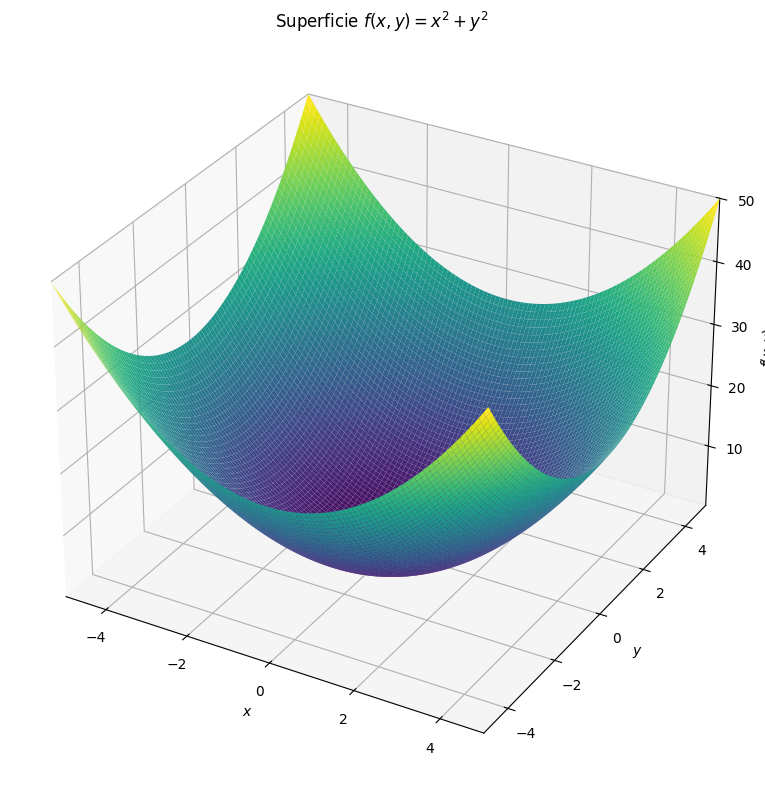

In [30]:
plot_surface(x**2+y**2, (x, -5, 5), (y, -5, 5),r"Superficie $f(x,y)=x^2 + y^2$")

In [31]:
def graphic_gradient_descent(
        f: Callable[[np.ndarray, np.ndarray], np.ndarray],
        df: Callable[[np.ndarray], np.ndarray],
        resolution: int = 100,
        min_range: float = -5.5,
        max_range: float = 5.5,
        learning_rate: float = .1,  #Tasa de aprendizaje. Fija. Sería más efectivo reducirlo a medida que nos acercamos.
        max_iterations: int = 50,
        tol: float = 1e-6,
):
    #Prepara los datos para dibujar mapa de niveles de Z
    x = np.linspace(min_range, max_range, resolution)
    y = np.linspace(min_range, max_range, resolution)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)

    # Pinta el mapa de niveles de Z
    plt.contourf(X, Y, Z, resolution, cmap="viridis")
    plt.colorbar()

    # Generamos un punto aleatorio inicial y pintamos de blanco
    p = np.array([random.uniform(-5, 5), random.uniform(-5, 5)])
    plt.plot(p[0], p[1], "o", c="white")

    for _ in range(max_iterations):
        try:
            grad = df(p)
        except OverflowError:
            print("No hay convergido a alguna solución, se ha desbordado, "
                  "revise la tasa de aprendizaje, o con algún otro punto de "
                  "origen")
            return
        gnorm = np.linalg.norm(grad, ord=2)
        # verificamos con la norma2 si ya está cerca de la tolerancia, para
        # finalizar el bucle, evitando calculos extra
        if gnorm < tol:
            break
        p = p - learning_rate * grad
        plt.plot(p[0], p[1], "o", c="red")

    #Dibujamos el punto final y pintamos de verde
    plt.plot(p[0], p[1], "o", c="green")
    print("Solución:", p, f(p[0],p[1]))
    plt.show()


Solución: [-4.44558223e-05  4.71114669e-05] 4.195810452751378e-09


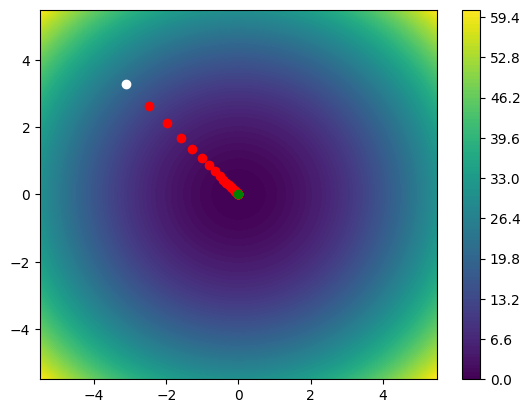

In [32]:
graphic_gradient_descent(f, df)

### ¿Te atreves a optimizar la función?:

$$
f(x,y)=sin \left(\frac{1}{2}x^2 - \frac{1}{4}y^2 + 3 \right) \cdot cos\left(2x + 1 - e^y \right)
$$

<!--
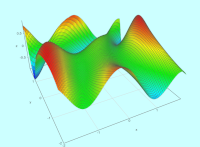
-->

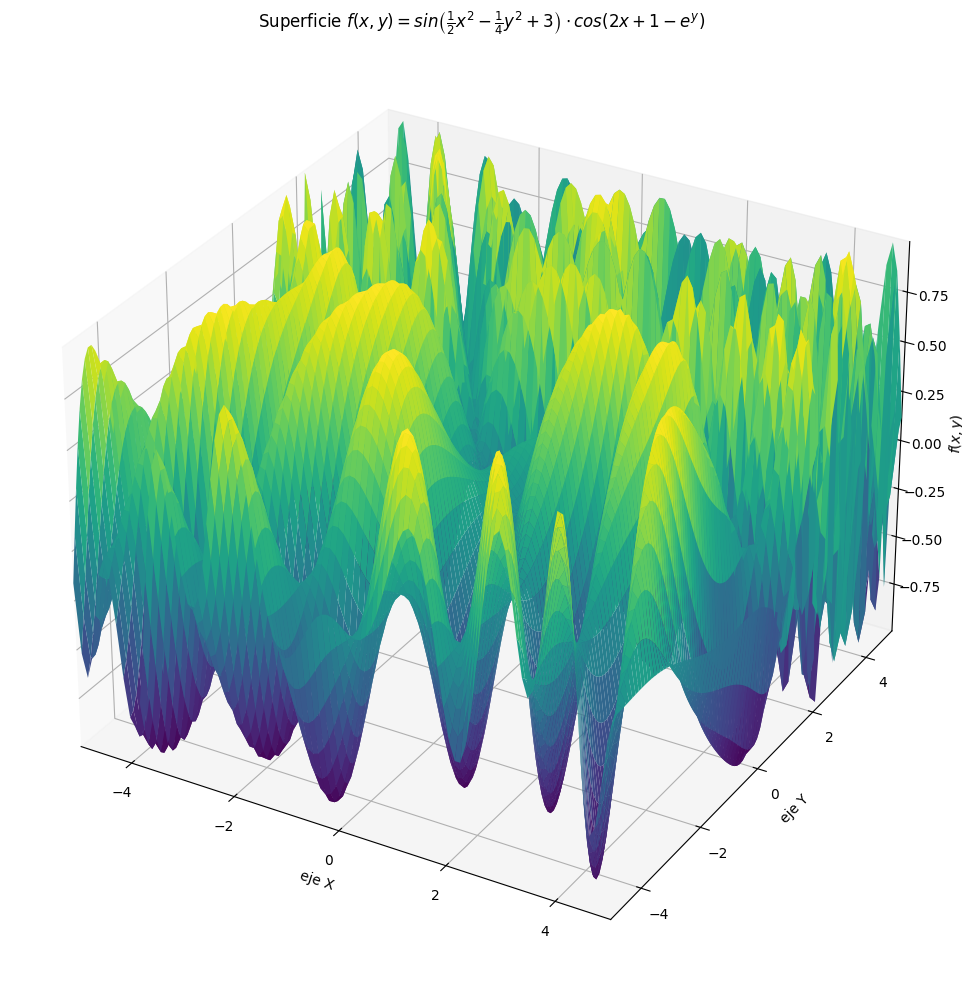

In [33]:
x, y = symbols('x y')
plot3d(
    sin(0.5 * x**2 - 0.25 * y**2 + 3) * cos(2*x + 1 - exp(y)),
    (x, -5, 5),
    (y, -5, 5),
    title=r"Superficie $f(x,y)=sin \left(\frac{1}{2}x^2 - \frac{1}{4}y^2 + 3 \right) \cdot cos\left(2x + 1 - e^y \right)$",
    xlabel='eje X',
    ylabel='eje Y',
    size=(10, 10)
)
plt.show()

### Calculando el gradiente de la función.

Dada la función $f(x,y)$, para encontrar el gradiente se procede a derivar
respectivamente con respecto a $x$ e $y$.

$$
\begin{array}{rcl}
\frac{df}{dx} & = & cos \left(\frac{1}{2}x^2 - \frac{1}{4}y^2 + 3 \right)(x) cos\left(2x + 1- e^y \right) + sin \left(\frac{1}{2}x^2 -\frac{1}{4}y^2 + 3 \right) (-1)  sin\left(2x + 1 -e^y \right) ( 2) \\
 & = & xcos \left(\frac{1}{2}x^2 - \frac{1}{4}y^2 + 3 \right) cos\left(2x + 1 - e^y \right)-2 sin \left(\frac{1}{2}x^2 -\frac{1}{4}y^2 + 3 \right) sin\left(2x + 1 - e^y \right) \\
\frac{df}{dy} & = & cos \left(\frac{1}{2}x^2 - \frac{1}{4}y^2 + 3 \right)(-\frac{y}{2}) cos\left(2x + 1- e^y \right) + sin \left(\frac{1}{2}x^2 -\frac{1}{4}y^2 + 3 \right) (-1)  sin\left(2x + 1 -e^y \right) (-e^y) \\
 & = & -\frac{y}{2} cos \left(\frac{1}{2}x^2 - \frac{1}{4}y^2 + 3 \right)
 cos\left(2x + 1 - e^y \right)+e^y sin \left(\frac{1}{2}x^2 -\frac{1}{4}y^2 + 3 \right) sin\left(2x + 1 - e^y \right)
\end{array}
$$

Por ende el gradiente de la funcion $f(x,y)$ es:
$$
\nabla f=\begin{bmatrix}
xcos \left(\frac{1}{2}x^2 - \frac{1}{4}y^2 + 3 \right) cos\left(2x + 1 - e^y \right)-2 sin \left(\frac{1}{2}x^2 -\frac{1}{4}y^2 + 3 \right) sin\left(2x + 1 - e^y \right)
 \\
-\frac{1}{2}y cos \left(\frac{1}{2}x^2 - \frac{1}{4}y^2 + 3 \right) cos\left(2x + 1 - e^y \right)+e^y sin \left(\frac{1}{2}x^2 -\frac{1}{4}y^2 + 3 \right) sin\left(2x + 1 - e^y \right)
\end{bmatrix}
$$

In [34]:
#Definimos la función
def f(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    return np.sin(0.5 * X**2 - 0.25 * Y**2 + 3) * np.cos(2 * X + 1 - np.exp(Y))

# este gradiente reescrito es algo larga con respecto al gradiente anterior
def df(X: np.ndarray) -> np.ndarray:
    x, y = X[0], X[1]
    # A = x^2/2 - y^2/4 + 3
    arg_sin = 0.5 * x**2 - 0.25 * y**2 + 3
    # B = 2x + 1 - e^y
    exp_y = np.exp(y)
    arg_cos = 2 * x + 1 - exp_y
    sin_A = np.sin(arg_sin)
    cos_A = np.cos(arg_sin)
    sin_B = np.sin(arg_cos)
    cos_B = np.cos(arg_cos)
    df_dx = x * cos_A * cos_B - 2 * sin_A * sin_B
    df_dy = -0.5 * y * cos_A * cos_B + exp_y * sin_A * sin_B
    return np.array([df_dx, df_dy])

print(f(0, 0))
print(df(np.array([0, 0])))

0.1411200080598672
[-0.  0.]


Solución: [ 1.09769788 -2.84719296] -0.9999784277202232


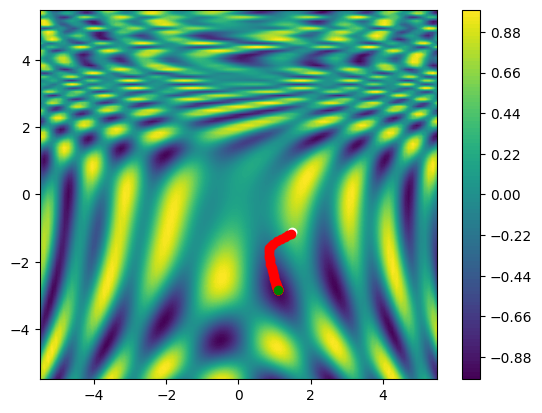

In [59]:
graphic_gradient_descent(f, df)

### Aproximando el gradiente con la aproximación de la derivada

Para obtener el gradiente de la función de manera aproximada, se hace uso de
la definición formal de la derivada:

$$
f'(a) = \lim_{\substack{
{x\to 0} \\
}} \frac{f(a+h)-f(a)}{h}
$$

Esta forma de derivar también es conocida como derivada hacia adelante.

In [36]:
def df_approx_forward(X: np.ndarray, a:float = 0.01) -> np.ndarray:
    X = X.astype(float)
    grad = np.zeros_like(X)
    for i in range(len(X)):
        X_plus = X.copy()
        X_plus[i] += a
        grad[i] = (f(X_plus[0], X_plus[1]) - f(X[0], X[1])) / a
    return grad

print("a=0.01")
print(df_approx_forward(np.array([0, 0])))
print(f"Diferencia: {np.linalg.norm(df(np.array([0, 0])) - df_approx_forward(np.array([0, 0])))}")
print("a=0.0001")
print(df_approx_forward(np.array([0, 0]), 0.0001))
print(f"Diferencia: {np.linalg.norm(df(np.array([0, 0])) - df_approx_forward(np.array([0, 0]), 0.0001))}")

a=0.01
[-0.0077713   0.00176216]
Diferencia: 0.007968579217248499
a=0.0001
[-7.77236248e-05  1.76931084e-05]
Diferencia: 7.971203127061816e-05


El uso de la derivada hacia adelante según [Wikipedia](https://en.wikipedia.org/wiki/Numerical_differentiation) debería ser
aceptable siempre y cuando el valor de `a` sea relativamente bajo. Su error
es de orden $O(h)$ (lineal).

Sin embargo, existe otra aproximación de derivación numerica que ofrece un
error más bajo con respecto a derivar hacia adelante. Dicho método se lo
conoce como derivación por diferencias centradas, el cual tiene un error en
el orden $O(h^2)$ (cuadrático).

En órdenes de Error, lo ideal es que tenga mayor magnitud, por lo que la
aproximación bajo el uso de diferencias centradas ofrece un resultado mucho
más cercano a obtener el gradiente por metodos matemáticos.

$$
f'(a) = \lim_{\substack{
{x\to 0} \\
}} \frac{f(a+h)-f(a-h)}{2h}
$$

In [37]:
def df_approx_central(X: np.ndarray, a:float = 0.01) -> np.ndarray:
    X = X.astype(float)
    grad = np.zeros_like(X)

    for i in range(len(X)):
        X_plus = X.copy()
        X_minus = X.copy()
        X_plus[i] += a
        X_minus[i] -= a
        f_plus = f(X_plus[0], X_plus[1])
        f_minus = f(X_minus[0], X_minus[1])
        grad[i] = (f_plus - f_minus) / (2*a)

    return grad

print("a=0.01")
print(df_approx_central(np.array([0, 0])))
print(f"Diferencia: {np.linalg.norm(df(np.array([0, 0])) - df_approx_central(np.array([0, 0])))}")
print("a=0.0001")
print(df_approx_central(np.array([0, 0]), 0.0001))
print(f"Diferencia: {np.linalg.norm(df(np.array([0, 0])) - df_approx_central(np.array([0, 0]), 0.0001))}")

a=0.01
[ 0.00000000e+00 -7.05729669e-06]
Diferencia: 7.0572966942572535e-06
a=0.0001
[ 0.00000000e+00 -7.05546732e-10]
Diferencia: 7.05546732149287e-10


Solución: [4.18279305 0.95249097] -0.7631862124184553


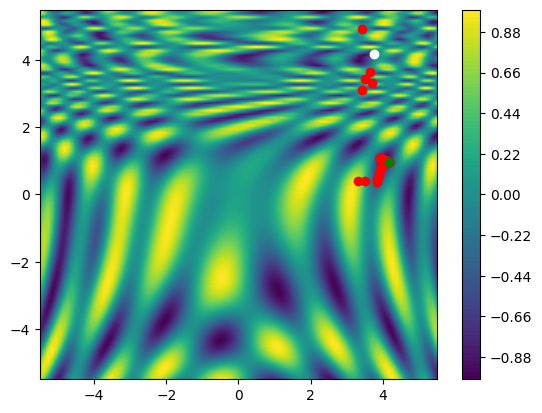

In [58]:
graphic_gradient_descent(f, df_approx_forward)

Solución: [ 2.69178946 -2.78174249] -0.9989714951898214


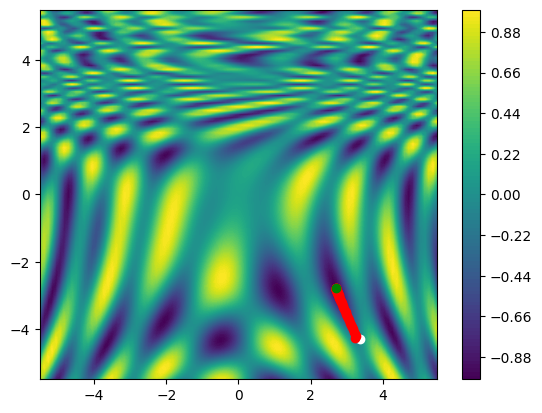

In [44]:
graphic_gradient_descent(f, df_approx_central)

Graficamente, se intuye que el usar la gradiente con las diferencias
centrales converge a la solucion de manera mas suave que usando la derivada
hacia adelante.

# Nota sobre el uso de herramientas de IA generativa

En la elaboración de este notebook se emplearon herramientas de inteligencia artificial generativa de forma puntual y como apoyo complementario, con los siguientes fines específicos:

1. Asistencia en la creación de métodos para la impresión de tablas de costes y la visualización de resultados, con el objetivo de presentar de forma más clara y amigable las salidas del problema de asignación de tareas.
2. Orientación para la creación de un paquete instalable relacionado con la mejora de la visualización de resultados, con el fin de desacoplar código auxiliar y evitar la saturación del notebook con implementaciones no centrales para el análisis.
3. Formateo de secciones del documento mediante HTML, con el propósito de mejorar la coherencia estructural y la presentación visual del contenido.
4. Síntesis y clarificación de conceptos complejos, incluyendo el análisis de complejidad computacional (Big O Notation) y la explicación de los algoritmos, utilizadas como apoyo conceptual previo para que el autor pudiera posteriormente replicar e implementar las soluciones por cuenta propia.
5. Apoyo en la interpretación de los resultados obtenidos al aplicar distintos algoritmos de asignación de tareas, con el objetivo de orientar optimizaciones posteriores del código, las cuales fueron finalmente diseñadas e implementadas por el autor.
6. Asistencia en el formateo de ecuaciones matemáticas mediante $LaTeX$, para una presentación clara y consistente de los desarrollos teóricos.
7. Corroboración del cálculo de gradientes, utilizando herramientas computacionales externas como Wolfram Alpha, empleadas exclusivamente con fines de verificación.

El resto del contenido del documento: la redacción, el desarrollo principal del código, el diseño metodológico y la interpretación de los resultados es de autoría propia o se basa en material proporcionado en clase y en recursos disponibles públicamente, los cuales han sido reinterpretados, adaptados y reelaborados para los fines de este trabajo.

# Referencias Bibliográficas

* [1<a id="img1"></a>] ["Numerical differentiation," Wikipedia, The Free Encyclopedia. [Online]](https://en.wikipedia.org/wiki/Numerical_differentiation). [Accedido: 01-feb-2026]